In [1]:
# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster()
# client = Client(cluster)

In [2]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=16,processes=1,memory="47GB")
client = Client(cluster)
cluster.scale(cores=48)

/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
print(client)

<Client: 'tcp://10.0.128.165:45447' processes=0 threads=0, memory=0 B>


In [4]:
cd /g/data/fu5/deg581/OSSE_analysis/notebooks/

/g/data1a/fu5/deg581/OSSE_analysis/notebooks


In [5]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)


loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


In [6]:
### new loads
import numpy.matlib
from xgcm import Grid
import matplotlib.ticker as mticker


### Load functions

In [7]:
### Other local functions

def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = glob.glob(hisFilePath+prefix+filestring)

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadOSSEFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName


def loadOverlappedNetcdf(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = sorted(glob.glob(hisFilePath+prefix+filestring))

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadOverlappedNetcdfFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    # err=err2**(1/2)
    mse = indexMeanMetric(err2,etaRange,xiRange) #mean square error MSE
    output = mse**(1/2)
    return mse,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    ''' iRange and jRange are converted to slices, so they are the start/end values of the range '''
    output = input.isel(eta_rho=slice(etaRange[0],etaRange[1]), xi_rho=slice(xiRange[0],xiRange[1])).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def plot_spatialMapSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def plot_spatialMapGSSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

def datestring_to_serial_day(datestring,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import pandas as pd
    import datetime
    serial_day_timedelta = pd.to_datetime(datestring) - datetime.datetime(epochY,epochm,epochd,epochH,epochM)
    corrected_serial_day_number = serial_day_timedelta.days + serial_day_timedelta.seconds/86400
    return corrected_serial_day_number


def serial_day_to_datestring(day,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import datetime
    corrected_date = datetime.datetime(epochY,epochm,epochd,epochH,epochM) + datetime.timedelta(day)
    return corrected_date.strftime("%Y-%m-%d %H:%M")  

In [8]:
### Functions for calculating metrics

def loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates):
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    return sshForecast, sshAnalysis, sstForecast, sstAnalysis

def loadTruthdata(hisTruthFilePath,prefixTruth,dates):
    filenameTruth   =hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()
    return sshTruth, sstTruth

def compileOSSETimeMetricSSH(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            ssh_metricForecast = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
            temp = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
    return ssh_metricForecast,ssh_metricAnalysis

def compileOSSETimeMetricSST(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            sst_metricForecast = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricForecast = xr.merge([sst_metricForecast, temp])
            temp = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])
    return sst_metricForecast,sst_metricAnalysis

def compileTruthTimeMetric(hisTruthFilePath,prefixTruth,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshTruth,sstTruth = loadTruthdata(hisTruthFilePath,prefixTruth,dates)
        if dates == datelist[0]:
            ssh_metricTruth = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
            temp = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = xr.merge([sst_metricTruth, temp])
    return ssh_metricTruth, sst_metricTruth

In [9]:
### Functions for loading and processing ROMS data nicely... ROMS FUNCTIONS


def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    periodic=False)
    
    return gridOut

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho'],
                                    method='linear').squeeze()
    return output

In [10]:

def loadOSSEFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadOverlappedNetcdfFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadNetcdfFileListAverages(hisFilePath,prefix,filelist):

    outName = xr.open_mfdataset(filelist, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def generateFileList(hisFilePath,prefix,datelist):
    filelist=[hisFilePath+prefix+'0'+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=hisFilePath+prefix+'0'+str(dates)+'.nc'
        filelist.append(filenameToAppend)

#         print(filelist)
    return filelist

# downsample data to daily.
def calc_dailyDownsample(ds):
    ds_withtime = ds.drop([ var for var in ds.variables if not 'ocean_time' in ds[var].dims ])
    ds_timeless = ds.drop([ var for var in ds.variables if     'ocean_time' in ds[var].dims ])
    ds_workaround = xr.merge([ds_timeless, ds_withtime.resample(ocean_time='5D').mean('ocean_time')])
    return ds_workaround

# calculate EKE metrics
def calc_timeMeanEKE(input):
    u_eastward_top = input.u_eastward.isel(s_rho=-1)
    v_northward_top = input.v_northward.isel(s_rho=-1)

    u_bar = u_eastward_top.mean("ocean_time")
    v_bar = v_northward_top.mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward_top - u_bar
    v_prime = v_northward_top - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)

    eketimemean = (eke*input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return eketimemean

def calc_MKEandEKElevel(input,level):
    u_eastward = input.u_eastward
    v_northward = input.v_northward

    u_bar = u_eastward.isel(s_rho=level).mean("ocean_time")
    v_bar = v_northward.isel(s_rho=level).mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward.isel(s_rho=level) - u_bar
    v_prime = v_northward.isel(s_rho=level) - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)
    
    input['mke']=mke
    input['eke']=eke
    return input

def calc_MKEandEKEall(input):
    u_eastward = input.u_eastward
    v_northward = input.v_northward

    u_bar = u_eastward.mean("ocean_time")
    v_bar = v_northward.mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward - u_bar
    v_prime = v_northward - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)
    
    input['mke']=mke
    input['eke']=eke
    return input

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho0'],
                                    method='linear').squeeze()
    return output

def calc_areaAverageROMS(input,grid):
    output = (input*grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return output

def calc_areaMedianROMS(input,grid):
    output = input*(grid.dA/grid.dA.sum(dim=['eta_rho','xi_rho'],skipna=True))
    output = np.median(output.values.flatten())
    return output

def process_trimVarsROMS(input,varsKeep):
    output_backup = input
    output = input[varsKeep]
    return output,output_backup

def calc_volTrans(input,etaLocation,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw<=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked.isel(eta_rho=transectEta)*input.dz.isel(eta_rho=transectEta)*input.dx.isel(eta_rho=transectEta)).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_volTransSlice(input,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw<=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked*input.dz*input.dx).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_volTransSliceNorth(input,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw>=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked*input.dz*input.dx).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_depthAverageROMS(input,grid,etaTransect):
    dz = grid.dz.mean(dim='ocean_time').isel(eta_rho=etaTransect)
    dx = grid.dx.isel(eta_rho=etaTransect)
    output = ((input*dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True))/(dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True)
    return output

In [11]:
hisTruthFilePath='/g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/' # Truth file settings

hisOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
modOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
obsOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'

hisOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
modOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
obsOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'

hisOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
modOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
obsOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'

hisOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
modOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
obsOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'

hisOSSEFilePath5='/g/data/fu5/deg581/OSSE_SSHSST_XBT_PXLINES/output/'
modOSSEFilePath5='/g/data/fu5/deg581/OSSE_SSHSST_XBT_PXLINES/output/'
obsOSSEFilePath5='/g/data/fu5/deg581/OSSE_SSHSST_XBT_PXLINES/output/'

prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
prefixTruth='outer_his_'
prefixObs='obs_0'
prefixMod='eac_mod_'
prefixPert='outer_his_'

outFigurePath='../cache/out/'

In [12]:
timeRange = [8005, 8401]
datelist = np.array(range(timeRange[0],timeRange[1],4))


In [13]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

In [14]:

# datelist = np.array(range(timeRange[0],timeRange[1],4))

# filelist=[hisOSSEFilePath1+prefixAnalysis+''+str(datelist[0])+'.nc']
# for dates in datelist[1:]:
#     filenameToAppend=hisOSSEFilePath1+prefixAnalysis+''+str(dates)+'.nc'
#     filelist.append(filenameToAppend)

# print(filelist)

In [15]:
# truth.close(), print('done')
# OSSE_SSHSST.close(), print('done')
# OSSE_SSHSST_XBT_N.close(), print('done')
# OSSE_SSHSST_XBT_S.close(), print('done')
# OSSE_SSHSST_XBT.close(), print('done')

In [16]:
# Load zeta data
VarToKeep = ['temp','z_rho0','dx','dy','dz','u_eastward','v_northward']

outputPath = '/g/data/fu5/deg581/OSSE_analysis/data/proc/'
outputPrefix = 'output_'
outputSuffix = '_'+str(timeRange[0])+'_'+str(timeRange[1])+'.nc'
filelistTruth = outputPath+outputPrefix+'truth'+outputSuffix
filelist_baseline_barra=outputPath+outputPrefix+'perturbed_test'+outputSuffix
filelist_baseline_access=outputPath+outputPrefix+'baseline_access_100dt'+outputSuffix


truth = xr.open_dataset(filelistTruth)
baseline_barra = xr.open_dataset(filelist_baseline_barra)
baseline_access = xr.open_dataset(filelist_baseline_access)

#load grid file

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    periodic=False,
    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    })
    return gridOut


grid = makeROMSGridObject(truth)

truth,truth_bu = process_trimVarsROMS(truth,VarToKeep)
truth = truth.drop('z_rho')
truth["z_rho0"] = truth.z_rho0.fillna(0)

baseline_barra,baseline_barra_bu = process_trimVarsROMS(baseline_barra,VarToKeep)
baseline_barra = baseline_barra.drop('z_rho')
baseline_barra["z_rho0"] = baseline_barra.z_rho0.fillna(0)

baseline_access,baseline_access_bu = process_trimVarsROMS(baseline_access,VarToKeep)
baseline_access = baseline_access.drop('z_rho')
baseline_access["z_rho0"] = baseline_access.z_rho0.fillna(0)

In [17]:
time_range_to_load = slice('2012-01-01','2013-01-01')

truth = truth.sel(ocean_time=time_range_to_load)
baseline_barra = baseline_barra.sel(ocean_time=time_range_to_load)
baseline_access = baseline_access.sel(ocean_time=time_range_to_load)



In [18]:
truth.load(), print('done')
baseline_barra.load(), print('done')
baseline_access.load(), print('done')


done
done
done


(<xarray.Dataset>
 Dimensions:      (ocean_time: 74, s_rho: 30, eta_rho: 317, xi_rho: 272)
 Coordinates:
     z_rho0       (eta_rho, xi_rho, s_rho) float64 0.0 0.0 0.0 ... -4.499 -1.051
   * s_rho        (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
     lon_rho      (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
     lat_rho      (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
   * ocean_time   (ocean_time) datetime64[ns] 2012-01-01 ... 2012-12-31
 Dimensions without coordinates: eta_rho, xi_rho
 Data variables:
     temp         (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 23.74
     dx           (eta_rho, xi_rho) float64 2.996e+03 2.996e+03 ... 6e+03 6e+03
     dy           (eta_rho, xi_rho) float64 5e+03 4.999e+03 ... 4.881e+03
     dz           (ocean_time, s_rho, eta_rho, xi_rho) float64 0.0 0.0 ... 3.178
     u_eastward   (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 0.0
     v_northward  (ocean_time, s_rho, eta

In [19]:
# calculate metrics

tempSurf = truth.temp.isel(s_rho=-1)
temp250 = horizontalSectionROMS(grid, truth.temp, np.array([-250]))
temp500 = horizontalSectionROMS(grid, truth.temp, np.array([-500]))
temp1000= horizontalSectionROMS(grid, truth.temp, np.array([-1000]))


RMSD_baseline_barra_TRUTH_temp    = (((baseline_barra.temp.isel(s_rho=-1)-truth.temp.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
RMSD_baseline_barra_TRUTH_temp500 = (((horizontalSectionROMS(grid, baseline_barra.temp, np.array([-500]))-horizontalSectionROMS(grid, truth.temp, np.array([-500])))**2).mean(dim='ocean_time'))**(1/2)
RMSD_baseline_barra_TRUTH_temp250   = (((horizontalSectionROMS(grid, baseline_barra.temp, np.array([-250]))-horizontalSectionROMS(grid, truth.temp, np.array([-250])))**2).mean(dim='ocean_time'))**(1/2)
RMSD_baseline_barra_TRUTH_temp1000   = (((horizontalSectionROMS(grid, baseline_barra.temp, np.array([-1000]))-horizontalSectionROMS(grid, truth.temp, np.array([-1000])))**2).mean(dim='ocean_time'))**(1/2)
# RMSD_baseline_barra_TRUTH_zeta   = (((baseline_barra.zeta-truth.zeta)**2).mean(dim='ocean_time'))**(1/2)

RMSD_baseline_access_TRUTH_temp    = (((baseline_access.temp.isel(s_rho=-1)-truth.temp.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
RMSD_baseline_access_TRUTH_temp500 = (((horizontalSectionROMS(grid, baseline_access.temp, np.array([-500]))-horizontalSectionROMS(grid, truth.temp, np.array([-500])))**2).mean(dim='ocean_time'))**(1/2)
RMSD_baseline_access_TRUTH_temp250   = (((horizontalSectionROMS(grid, baseline_access.temp, np.array([-250]))-horizontalSectionROMS(grid, truth.temp, np.array([-250])))**2).mean(dim='ocean_time'))**(1/2)
RMSD_baseline_access_TRUTH_temp1000   = (((horizontalSectionROMS(grid, baseline_access.temp, np.array([-1000]))-horizontalSectionROMS(grid, truth.temp, np.array([-1000])))**2).mean(dim='ocean_time'))**(1/2)
# RMSD_baseline_access_TRUTH_zeta   = (((baseline_access.zeta-truth.zeta)**2).mean(dim='ocean_time'))**(1/2)

In [20]:
weights = truth_bu.dA
weights.name = "weights"
etaLims = (39,201) #exclusive mask
xiLims = (100,200)
mask = (np.ones((truth.dims['eta_rho'],truth.dims['xi_rho']))*(truth.lon_rho*0+1)).where((truth.eta_rho>etaLims[0]) & (truth.eta_rho<etaLims[1]) & (truth.xi_rho>xiLims[0]) & (truth.xi_rho<xiLims[1]))

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

In [21]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


Text(0.5, 1.0, '')

<Figure size 600x400 with 0 Axes>

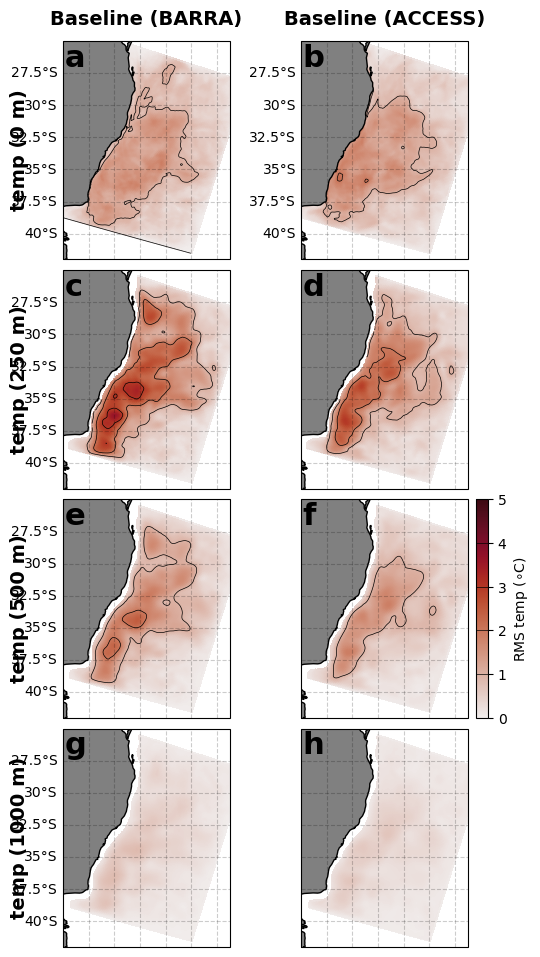

In [22]:
## define

def addSubplot_spatialMap(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax,gl,im

def addSubplot_spatialMap_colorbar(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.05,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    cbar = fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax,gl,im,cbar


# gs to make a 4 row, 7 col plot
gs = gridspec.GridSpec(nrows=4,ncols=2,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[6,12])
ax = None



levels=np.arange(-100,110,25)



ax = addSubplot_spatialMap(RMSD_baseline_barra_TRUTH_temp   ,gs,0,0,'a',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':5})
co = RMSD_baseline_barra_TRUTH_temp.plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(0,6,1),colors='k',zorder=12,linewidths=0.5)
ax[1].left_labels = True
# cbar.add_lines(co)
ax[0].set_title('')
ax[0].text(0.5, 1.1, 'Baseline (BARRA)',fontsize=14, fontweight='bold', va='center', ha='center', rotation='horizontal', transform=ax[0].transAxes)
# transectEta=255
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# ax[0].text(.05, .03, '$\overline{\mathrm{RMS}}$='+str(np.round( grid.average(RMSD_SSHSST_PXLINES_WEEKLY_TRUTH_temp250,['X','Y']).values,2))+'$\!^\circ\!$C',fontsize=9, va='center', ha='left', transform=ax[0].transAxes)
# ax[0].text(.45, .03,  '$\overline{\mathrm{RMS}\,}_\mathrm{EDDY}$='+str(np.round( RMSD_SSHSST_PXLINES_WEEKLY_TRUTH_temp250.where(mask==1).weighted(weights).mean(('eta_rho','xi_rho')).values,2))+'$\!^\circ\!$C',fontsize=9, va='center', ha='left', transform=ax[0].transAxes)
# boxLo,boxLa = calc_boxSpatial(truth,etaRange=etaLims,xiRange=xiLims)
# plt.plot(boxLo,boxLa,color='C0',linewidth=1)
ax[0].text(-.26, .5, 'temp (0 m)',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)



ax = addSubplot_spatialMap(RMSD_baseline_barra_TRUTH_temp250   ,gs,1,0,'c',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':5})
co = RMSD_baseline_barra_TRUTH_temp250.plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(0,6,1),colors='k',zorder=12,linewidths=0.5)
ax[1].left_labels = True
ax[0].set_title('')
# ax[0].text(.05, .03, '$\overline{\mathrm{RMS}}$='+str(np.round( grid.average(RMSD_baseline_barra_TRUTH_temp250,['X','Y']).values,2))+'$\!^\circ\!$C',fontsize=9, va='center', ha='left', transform=ax[0].transAxes)
# ax[0].text(.45, .03,  '$\overline{\mathrm{RMS}\,}_\mathrm{EDDY}$='+str(np.round( RMSD_baseline_barra_TRUTH_temp250.where(mask==1).weighted(weights).mean(('eta_rho','xi_rho')).values,2))+'$\!^\circ\!$C',fontsize=9, va='center', ha='left', transform=ax[0].transAxes)
# boxLo,boxLa = calc_boxSpatial(truth,etaRange=etaLims,xiRange=xiLims)
# plt.plot(boxLo,boxLa,color='C0',linewidth=1)
ax[0].text(-.26, .5, 'temp (250 m)',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)


ax = addSubplot_spatialMap(RMSD_baseline_barra_TRUTH_temp500   ,gs,2,0,'e',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':5})
co = RMSD_baseline_barra_TRUTH_temp500.plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(0,6,1),colors='k',zorder=12,linewidths=0.5)
ax[1].left_labels = True
ax[0].set_title('')
# ax[0].text(.05, .03, '$\overline{\mathrm{RMS}}$='+str(np.round( grid.average(RMSD_baseline_barra_TRUTH_temp500,['X','Y']).values,2))+'$\!^\circ\!$C',fontsize=9, va='center', ha='left', transform=ax[0].transAxes)
# ax[0].text(.45, .03,  '$\overline{\mathrm{RMS}\,}_\mathrm{EDDY}$='+str(np.round( RMSD_baseline_barra_TRUTH_temp500.where(mask==1).weighted(weights).mean(('eta_rho','xi_rho')).values,2))+'$\!^\circ\!$C',fontsize=9, va='center', ha='left', transform=ax[0].transAxes)
# boxLo,boxLa = calc_boxSpatial(truth,etaRange=etaLims,xiRange=xiLims)
# plt.plot(boxLo,boxLa,color='C0',linewidth=1)
ax[0].text(-.26, .5, 'temp (500 m)',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)


ax = addSubplot_spatialMap(RMSD_baseline_barra_TRUTH_temp1000   ,gs,3,0,'g',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':5})
co = RMSD_baseline_barra_TRUTH_temp1000.plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(0,6,1),colors='k',zorder=12,linewidths=0.5)
ax[1].left_labels = True
ax[0].set_title('')
# ax[0].text(.05, .03, '$\overline{\mathrm{RMS}}$='+str(np.round( grid.average(RMSD_baseline_barra_TRUTH_temp1000,['X','Y']).values,2))+'$\!^\circ\!$C',fontsize=9, va='center', ha='left', transform=ax[0].transAxes)
# ax[0].text(.45, .03,  '$\overline{\mathrm{RMS}\,}_\mathrm{EDDY}$='+str(np.round( RMSD_baseline_barra_TRUTH_temp1000.where(mask==1).weighted(weights).mean(('eta_rho','xi_rho')).values,2))+'$\!^\circ\!$C',fontsize=9, va='center', ha='left', transform=ax[0].transAxes)
# boxLo,boxLa = calc_boxSpatial(truth,etaRange=etaLims,xiRange=xiLims)
# plt.plot(boxLo,boxLa,color='C0',linewidth=1)
ax[0].text(-.26, .5, 'temp (1000 m)',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)



### Col 2




ax = addSubplot_spatialMap(RMSD_baseline_access_TRUTH_temp   ,gs,0,1,'b',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':5})
co = RMSD_baseline_access_TRUTH_temp.plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(0,6,1),colors='k',zorder=12,linewidths=0.5)
ax[1].left_labels = True
ax[0].set_title('')
ax[0].text(0.5, 1.1, 'Baseline (ACCESS)',fontsize=14, fontweight='bold', va='center', ha='center', rotation='horizontal', transform=ax[0].transAxes)
# transectEta=255
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# ax[0].text(.05, .03, '$\overline{\mathrm{RMS}}$='+str(np.round( grid.average(RMSD_SSHSST_PXLINES_WEEKLY_TRUTH_temp250,['X','Y']).values,2))+'$\!^\circ\!$C',fontsize=9, va='center', ha='left', transform=ax[0].transAxes)
# ax[0].text(.45, .03,  '$\overline{\mathrm{RMS}\,}_\mathrm{EDDY}$='+str(np.round( RMSD_SSHSST_PXLINES_WEEKLY_TRUTH_temp250.where(mask==1).weighted(weights).mean(('eta_rho','xi_rho')).values,2))+'$\!^\circ\!$C',fontsize=9, va='center', ha='left', transform=ax[0].transAxes)
# boxLo,boxLa = calc_boxSpatial(truth,etaRange=etaLims,xiRange=xiLims)
# plt.plot(boxLo,boxLa,color='C0',linewidth=1)
# ax[0].text(-.26, .5, 'temp (0 m)',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)

ax = addSubplot_spatialMap(RMSD_baseline_access_TRUTH_temp250   ,gs,1,1,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':5})
co = RMSD_baseline_access_TRUTH_temp250.plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(0,6,1),colors='k',zorder=12,linewidths=0.5)
ax[1].left_labels = False
ax[0].set_title('')

ax = addSubplot_spatialMap(RMSD_baseline_access_TRUTH_temp500   ,gs,2,1,'f',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':5})
co = RMSD_baseline_access_TRUTH_temp500.plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(0,6,1),colors='k',zorder=12,linewidths=0.5)
ax[1].left_labels = False
ax[0].set_title('')
cax = inset_axes(ax[0],
                 width="7%",  # width = 10% of parent_bbox width
                 height="100%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(1.05,0, 1, 1),
                 bbox_transform=ax[0].transAxes,
                 borderpad=0,
                 )
cbar = fig.colorbar(ax[2], cax=cax)
cbar.ax.set_ylabel('RMS temp ($\circ$C)')
cbar.add_lines(co)

ax = addSubplot_spatialMap(RMSD_baseline_access_TRUTH_temp1000   ,gs,3,1,'h',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':5})
co = RMSD_baseline_access_TRUTH_temp1000.plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(0,6,1),colors='k',zorder=12,linewidths=0.5)
ax[1].left_labels = False
ax[0].set_title('')




# Calculate bias

In [23]:

bias_temp_baseline_barra = (baseline_barra.temp-truth.temp).mean(dim='ocean_time')
bias_temp_baseline_access = (baseline_access.temp-truth.temp).mean(dim='ocean_time')

bias_temp_baseline_barra["z_rho0"] = baseline_barra.z_rho0
bias_temp_baseline_access["z_rho0"] = baseline_access.z_rho0



In [24]:

etaTransect=255
x1 = truth.lon_rho.isel(eta_rho=etaTransect)
y1 = truth.z_rho0.isel(eta_rho=etaTransect)
x1,dump = xr.broadcast(x1,y1)
x1 = x1.transpose()
y1 = y1.transpose()

etaTransect=185
x2 = truth.lon_rho.isel(eta_rho=etaTransect)
y2 = truth.z_rho0.isel(eta_rho=etaTransect)
x2,dump = xr.broadcast(x2,y2)
x2 = x2.transpose()
y2 = y2.transpose()

etaTransect=119
x3 = truth.lon_rho.isel(eta_rho=etaTransect)
y3 = truth.z_rho0.isel(eta_rho=etaTransect)
x3,dump = xr.broadcast(x3,y3)
x3 = x3.transpose()
y3 = y3.transpose()



(150.0, 159.0)

<Figure size 600x400 with 0 Axes>

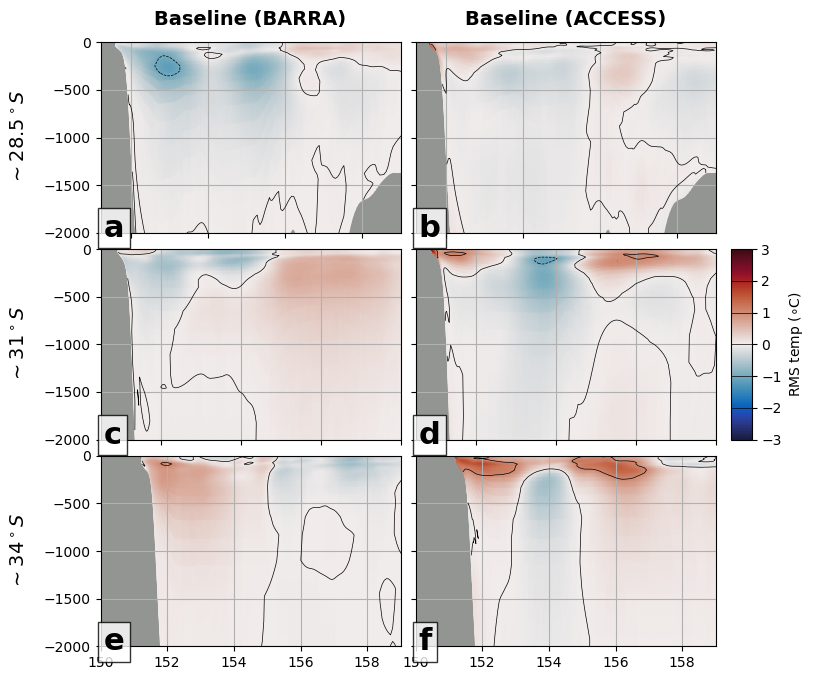

In [25]:
## test vertical transect

def addSubplot_VerticalTransect(X,Y,input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol])
    ax.set_facecolor('xkcd:grey')
    im = ax.pcolormesh(X,Y,input,shading='gouraud', **pcol_kwargs)
    # cax = inset_axes(ax,
    #              width="5%",  # width = 10% of parent_bbox width
    #              height="50%",  # height : 50%
    #              loc='lower left',
    #              bbox_to_anchor=(.05,.09, .8, .8),
    #              bbox_transform=ax.transAxes,
    #              borderpad=0,
    #              )
    ax.set_ylim([-2000,0])
    # cbar = fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.1, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
    ax.grid()
    return ax,im

def addSubplot_VerticalTransect_colorbar(X,Y,input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol])
    ax.set_facecolor('xkcd:grey')
    im = ax.pcolormesh(X,Y,input,shading='gouraud', **pcol_kwargs)
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.87,.56, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    cax.yaxis.tick_left()
    cax.set_ylabel('temp ($\circ C$)')
    ax.set_ylim([-2000,0])
    ax.text(0.01, 0.1, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
    ax.grid()
    return ax,cbar,im




gs = gridspec.GridSpec(nrows=3,ncols=3,wspace=0.05, hspace=0.085)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[12,8])
ax = None


# barra
ax = addSubplot_VerticalTransect(x1,y1,bias_temp_baseline_barra.isel(eta_rho=255),gs,0,0,'a',pcol_kwargs={'cmap':'cmo.balance','vmin':-3,'vmax':3})
co = ax[0].contour(x1,y1,bias_temp_baseline_barra.isel(eta_rho=255),levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
ax[0].text(-.27, .5, '$\sim28.5^\circ S$',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
ax[0].text(0.5, 1.12, 'Baseline (BARRA)',fontsize=14, fontweight='bold', va='center', ha='center', rotation='horizontal', transform=ax[0].transAxes)
ax[0].set_xlim([153.2,161])
ax[0].set_xticklabels([])

ax = addSubplot_VerticalTransect(x2,y2,bias_temp_baseline_barra.isel(eta_rho=185),gs,1,0,'c',pcol_kwargs={'cmap':'cmo.balance','vmin':-3,'vmax':3})
co = ax[0].contour(x2,y2,bias_temp_baseline_barra.isel(eta_rho=185),levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
ax[0].text(-.27, .5,  '$\sim31^\circ S$',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
ax[0].set_xticklabels([])
ax[0].set_xlim([152.5,160])

ax  = addSubplot_VerticalTransect(x3,y3,bias_temp_baseline_barra.isel(eta_rho=119),gs,2,0,'e',pcol_kwargs={'cmap':'cmo.balance','vmin':-3,'vmax':3})
co = ax[0].contour(x3,y3,bias_temp_baseline_barra.isel(eta_rho=119),levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
ax[0].text(-.27, .5,  '$\sim34^\circ S$',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
# ax[0].set_yticklabels([])
ax[0].set_xlim([150,159])

# baseline_access
ax = addSubplot_VerticalTransect(x1,y1,bias_temp_baseline_access.isel(eta_rho=255),gs,0,1,'b',pcol_kwargs={'cmap':'cmo.balance','vmin':-3,'vmax':3})
co = ax[0].contour(x1,y1,bias_temp_baseline_access.isel(eta_rho=255),levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
# ax[0].text(-.27, .5, '$\sim27.5^\circ S$',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
ax[0].text(0.5, 1.12, 'Baseline (ACCESS)',fontsize=14, fontweight='bold', va='center', ha='center', rotation='horizontal', transform=ax[0].transAxes)
ax[0].set_xlim([153.2,161])
ax[0].set_yticklabels([])
ax[0].set_xticklabels([])

ax = addSubplot_VerticalTransect(x2,y2,bias_temp_baseline_access.isel(eta_rho=185),gs,1,1,'d',pcol_kwargs={'cmap':'cmo.balance','vmin':-3,'vmax':3})
co = ax[0].contour(x2,y2,bias_temp_baseline_access.isel(eta_rho=185),levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
# ax[0].text(-.27, .5,  '$\sim32^\circ S$',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_xlim([152.5,160])
cax = inset_axes(ax[0],
                 width="7%",  # width = 10% of parent_bbox width
                 height="100%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(1.05,0, 1, 1),
                 bbox_transform=ax[0].transAxes,
                 borderpad=0,
                 )
cbar = fig.colorbar(ax[1], cax=cax)
cbar.ax.set_ylabel('RMS temp ($\circ$C)')
cbar.add_lines(co)

ax  = addSubplot_VerticalTransect(x3,y3,bias_temp_baseline_access.isel(eta_rho=119),gs,2,1,'f',pcol_kwargs={'cmap':'cmo.balance','vmin':-3,'vmax':3})
co = ax[0].contour(x3,y3,bias_temp_baseline_access.isel(eta_rho=119),levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
# ax[0].text(-.27, .5,  '$\sim35.5^\circ S$',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
# ax[0].set_yticklabels([])
ax[0].set_yticklabels([])
ax[0].set_xlim([150,159])






In [26]:
ax

(<AxesSubplot:>, <matplotlib.collections.QuadMesh at 0x7fb8a4c18ee0>)

<Figure size 600x400 with 0 Axes>

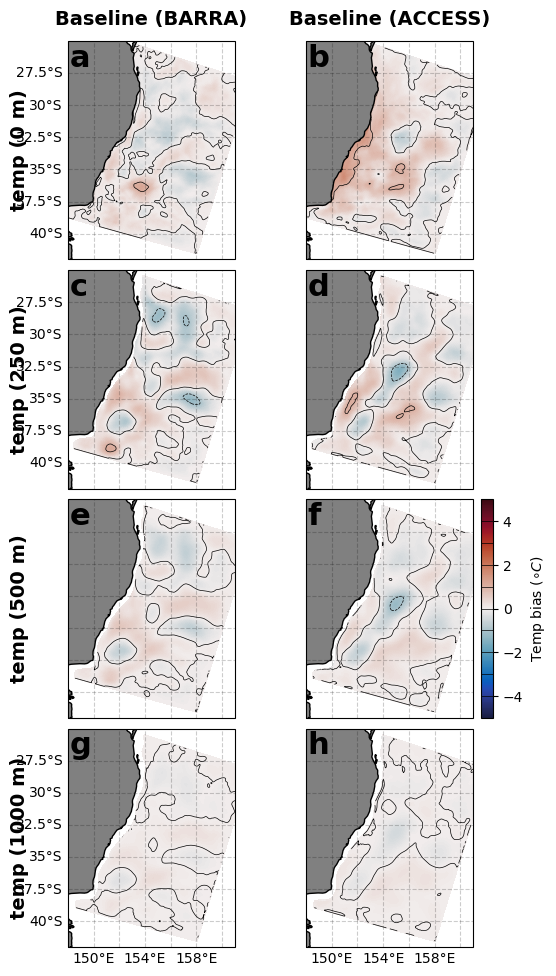

In [27]:

## define

def addSubplot_spatialMap(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax,gl,im

def addSubplot_spatialMap_colorbar(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.05,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    cbar = fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax,gl,im,cbar


# gs to make a 4 row, 7 col plot
gs = gridspec.GridSpec(nrows=4,ncols=2,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[6,12])
ax = None



levels=np.arange(-100,110,25)

#

ax = addSubplot_spatialMap(bias_temp_baseline_barra.isel(s_rho=-1)   ,gs,0,0,'a',pcol_kwargs={'cmap':'cmo.balance','vmin':-5,'vmax':5})
co = (bias_temp_baseline_barra.isel(s_rho=-1)).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
ax[1].left_labels = True
# cbar.add_lines(co)
ax[0].set_title('')
ax[0].text(0.5, 1.1, 'Baseline (BARRA)',fontsize=14, fontweight='bold', va='center', ha='center', rotation='horizontal', transform=ax[0].transAxes)
# ax[0].text(.05, .08, '$\overline{\mathrm{Bias}}$='+str(np.round( grid.average(bias_temp_W125.isel(s_rho=-1),['X','Y']).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# ax[0].text(.45, .08,  '$\overline{\mathrm{Bias}\,}_\mathrm{EDDY}$='+str(np.round( bias_temp_W125.isel(s_rho=-1).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho')).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# boxLo,boxLa = calc_boxSpatial(truth,etaRange=etaLims,xiRange=xiLims)
# plt.plot(boxLo,boxLa,color='C0',linewidth=1)
ax[0].text(-.29, .5, 'temp (0 m)',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)


ax = addSubplot_spatialMap(horizontalSectionROMS(grid, bias_temp_baseline_barra, np.array([-250]))   ,gs,1,0,'c',pcol_kwargs={'cmap':'cmo.balance','vmin':-5,'vmax':5})
co = (horizontalSectionROMS(grid, bias_temp_baseline_barra, np.array([-250]))).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
ax[1].left_labels = True
# cbar.add_lines(co)
ax[0].set_title('')
# # ax[0].text(0.5, 1.1, 'W-12.5',fontsize=14, fontweight='bold', va='center', ha='center', rotation='horizontal', transform=ax[0].transAxes)
# transectEta=255
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# ax[0].text(.05, .08, '$\overline{\mathrm{Bias}}$='+str(np.round( grid.average(horizontalSectionROMS(grid, bias_temp_W125, np.array([-250])),['X','Y']).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# ax[0].text(.45, .08,  '$\overline{\mathrm{Bias}\,}_\mathrm{EDDY}$='+str(np.round( horizontalSectionROMS(grid, bias_temp_W125, np.array([-250])).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho')).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# boxLo,boxLa = calc_boxSpatial(truth,etaRange=etaLims,xiRange=xiLims)
# plt.plot(boxLo,boxLa,color='C0',linewidth=1)
ax[0].text(-.29, .5, 'temp (250 m)',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)

ax = addSubplot_spatialMap(horizontalSectionROMS(grid, bias_temp_baseline_barra, np.array([-500]))   ,gs,2,0,'e',pcol_kwargs={'cmap':'cmo.balance','vmin':-5,'vmax':5})
co = (horizontalSectionROMS(grid, bias_temp_baseline_barra, np.array([-500]))).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
# ax[1].left_labels = True
# # ax[1].bottom_labels = True
ax[0].set_title('')
# transectEta=255
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# ax[0].text(.05, .08, '$\overline{\mathrm{Bias}}$='+str(np.round( grid.average(horizontalSectionROMS(grid, bias_temp_W125, np.array([-500])),['X','Y']).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# ax[0].text(.45, .08,  '$\overline{\mathrm{Bias}\,}_\mathrm{EDDY}$='+str(np.round( horizontalSectionROMS(grid, bias_temp_W125, np.array([-500])).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho')).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
ax[0].text(-.29, .5, 'temp (500 m)',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)

ax = addSubplot_spatialMap(horizontalSectionROMS(grid, bias_temp_baseline_barra, np.array([-1000]))   ,gs,3,0,'g',pcol_kwargs={'cmap':'cmo.balance','vmin':-5,'vmax':5})
co = (horizontalSectionROMS(grid, bias_temp_baseline_barra, np.array([-1000]))).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
ax[0].set_title('')
ax[1].left_labels = True
ax[1].bottom_labels = True
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# ax[0].text(.05, .08, '$\overline{\mathrm{Bias}}$='+str(np.round( grid.average(horizontalSectionROMS(grid, bias_temp_W125, np.array([-1000])),['X','Y']).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# ax[0].text(.45, .08,  '$\overline{\mathrm{Bias}\,}_\mathrm{EDDY}$='+str(np.round( horizontalSectionROMS(grid, bias_temp_W125, np.array([-1000])).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho')).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
ax[0].text(-.29, .5, 'temp (1000 m)',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)



### Col 2


ax = addSubplot_spatialMap(bias_temp_baseline_access.isel(s_rho=-1)   ,gs,0,1,'b',pcol_kwargs={'cmap':'cmo.balance','vmin':-5,'vmax':5})
co = (bias_temp_baseline_access.isel(s_rho=-1)).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
# ax[1].left_labels = True
# cbar.add_lines(co)
ax[0].set_title('')
ax[0].text(0.5, 1.1, 'Baseline (ACCESS)',fontsize=14, fontweight='bold', va='center', ha='center', rotation='horizontal', transform=ax[0].transAxes)
# transectEta=255
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# ax[0].text(.05, .08, '$\overline{\mathrm{Bias}}$='+str(np.round( grid.average(bias_temp_2W125.isel(s_rho=-1),['X','Y']).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# ax[0].text(.45, .08,  '$\overline{\mathrm{Bias}\,}_\mathrm{EDDY}$='+str(np.round( bias_temp_2W125.isel(s_rho=-1).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho')).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# boxLo,boxLa = calc_boxSpatial(truth,etaRange=etaLims,xiRange=xiLims)
# plt.plot(boxLo,boxLa,color='C0',linewidth=1)
# ax[0].text(-.26, .5, 'temp (0 m)',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)


ax = addSubplot_spatialMap(horizontalSectionROMS(grid, bias_temp_baseline_access, np.array([-250]))   ,gs,1,1,'d',pcol_kwargs={'cmap':'cmo.balance','vmin':-5,'vmax':5})
co = (horizontalSectionROMS(grid, bias_temp_baseline_access, np.array([-250]))).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
# ax[1].left_labels = True
# cbar.add_lines(co)
ax[0].set_title('')
# # ax[0].text(0.5, 1.1, 'W-12.5',fontsize=14, fontweight='bold', va='center', ha='center', rotation='horizontal', transform=ax[0].transAxes)
# transectEta=255
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# ax[0].text(.05, .08, '$\overline{\mathrm{Bias}}$='+str(np.round( grid.average(horizontalSectionROMS(grid, bias_temp_2W125, np.array([-250])),['X','Y']).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# ax[0].text(.45, .08,  '$\overline{\mathrm{Bias}\,}_\mathrm{EDDY}$='+str(np.round( horizontalSectionROMS(grid, bias_temp_2W125, np.array([-250])).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho')).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# boxLo,boxLa = calc_boxSpatial(truth,etaRange=etaLims,xiRange=xiLims)
# plt.plot(boxLo,boxLa,color='C0',linewidth=1)
# ax[0].text(-.26, .5, 'temp (250 m)',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)

ax = addSubplot_spatialMap(horizontalSectionROMS(grid, bias_temp_baseline_access, np.array([-500]))   ,gs,2,1,'f',pcol_kwargs={'cmap':'cmo.balance','vmin':-5,'vmax':5})
co = (horizontalSectionROMS(grid, bias_temp_baseline_access, np.array([-500]))).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
# ax[1].left_labels = True
# ax[1].bottom_labels = True
ax[0].set_title('')
# transectEta=255
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# # ax[0].text(.05, .03, '$\overline{\mathrm{RMS}}$='+str(np.round( grid.average(RMSD_SSHSST_PXLINES_WEEKLY_TRUTH_temp500,['X','Y']).values,2))+'$\!^\circ\!$C',fontsize=9, va='center', ha='left', transform=ax[0].transAxes)
# ax[0].text(.05, .08, '$\overline{\mathrm{Bias}}$='+str(np.round( grid.average(horizontalSectionROMS(grid, bias_temp_2W125, np.array([-500])),['X','Y']).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# ax[0].text(.45, .08,  '$\overline{\mathrm{Bias}\,}_\mathrm{EDDY}$='+str(np.round( horizontalSectionROMS(grid, bias_temp_2W125, np.array([-500])).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho')).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
cax = inset_axes(ax[0],
                 width="7%",  # width = 10% of parent_bbox width
                 height="100%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(1.05,0, 1, 1),
                 bbox_transform=ax[0].transAxes,
                 borderpad=0,
                 )
cbar = fig.colorbar(ax[2], cax=cax)
cbar.ax.set_ylabel('Temp bias ($\circ C$)')
cbar.add_lines(co)

ax = addSubplot_spatialMap(horizontalSectionROMS(grid, bias_temp_baseline_access, np.array([-1000]))   ,gs,3,1,'h',pcol_kwargs={'cmap':'cmo.balance','vmin':-5,'vmax':5})
co = (horizontalSectionROMS(grid, bias_temp_baseline_access, np.array([-1000]))).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
ax[0].set_title('')
# ax[1].left_labels = True
ax[1].bottom_labels = True
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# # ax[0].text(.05, .03, '$\overline{\mathrm{RMS}}$='+str(np.round( grid.average(RMSD_SSHSST_PXLINES_WEEKLY_TRUTH_temp1000,['X','Y']).values,2))+'$\!^\circ\!$C',fontsize=9, va='center', ha='left', transform=ax[0].transAxes)
# ax[0].text(.05, .08, '$\overline{\mathrm{Bias}}$='+str(np.round( grid.average(horizontalSectionROMS(grid, bias_temp_2W125, np.array([-1000])),['X','Y']).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# ax[0].text(.45, .08,  '$\overline{\mathrm{Bias}\,}_\mathrm{EDDY}$='+str(np.round( horizontalSectionROMS(grid, bias_temp_2W125, np.array([-1000])).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho')).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)








In [28]:

bias_temp_baseline_barra2 = (baseline_barra.temp.mean(dim='ocean_time')-truth.temp.mean(dim='ocean_time'))
bias_temp_baseline_access2 = (baseline_access.temp.mean(dim='ocean_time')-truth.temp.mean(dim='ocean_time'))

bias_temp_baseline_barra2["z_rho0"] = baseline_barra.z_rho0
bias_temp_baseline_access2["z_rho0"] = baseline_access.z_rho0

<Figure size 600x400 with 0 Axes>

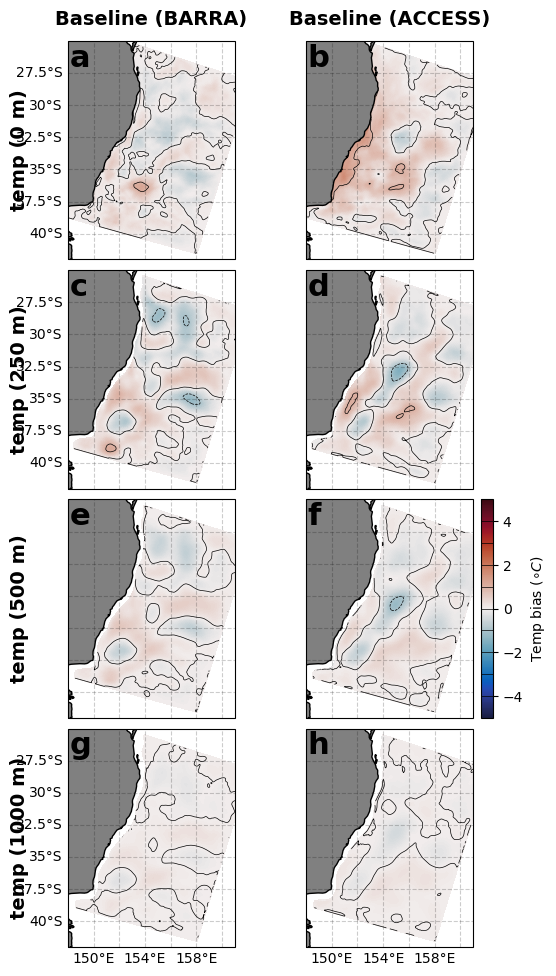

In [29]:

## define

def addSubplot_spatialMap(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax,gl,im

def addSubplot_spatialMap_colorbar(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.05,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    cbar = fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax,gl,im,cbar


# gs to make a 4 row, 7 col plot
gs = gridspec.GridSpec(nrows=4,ncols=2,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[6,12])
ax = None



levels=np.arange(-100,110,25)

#

ax = addSubplot_spatialMap(bias_temp_baseline_barra2.isel(s_rho=-1)   ,gs,0,0,'a',pcol_kwargs={'cmap':'cmo.balance','vmin':-5,'vmax':5})
co = (bias_temp_baseline_barra2.isel(s_rho=-1)).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
ax[1].left_labels = True
# cbar.add_lines(co)
ax[0].set_title('')
ax[0].text(0.5, 1.1, 'Baseline (BARRA)',fontsize=14, fontweight='bold', va='center', ha='center', rotation='horizontal', transform=ax[0].transAxes)
# ax[0].text(.05, .08, '$\overline{\mathrm{Bias}}$='+str(np.round( grid.average(bias_temp_W125.isel(s_rho=-1),['X','Y']).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# ax[0].text(.45, .08,  '$\overline{\mathrm{Bias}\,}_\mathrm{EDDY}$='+str(np.round( bias_temp_W125.isel(s_rho=-1).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho')).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# boxLo,boxLa = calc_boxSpatial(truth,etaRange=etaLims,xiRange=xiLims)
# plt.plot(boxLo,boxLa,color='C0',linewidth=1)
ax[0].text(-.29, .5, 'temp (0 m)',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)


ax = addSubplot_spatialMap(horizontalSectionROMS(grid, bias_temp_baseline_barra2, np.array([-250]))   ,gs,1,0,'c',pcol_kwargs={'cmap':'cmo.balance','vmin':-5,'vmax':5})
co = (horizontalSectionROMS(grid, bias_temp_baseline_barra2, np.array([-250]))).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
ax[1].left_labels = True
# cbar.add_lines(co)
ax[0].set_title('')
# # ax[0].text(0.5, 1.1, 'W-12.5',fontsize=14, fontweight='bold', va='center', ha='center', rotation='horizontal', transform=ax[0].transAxes)
# transectEta=255
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# ax[0].text(.05, .08, '$\overline{\mathrm{Bias}}$='+str(np.round( grid.average(horizontalSectionROMS(grid, bias_temp_W125, np.array([-250])),['X','Y']).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# ax[0].text(.45, .08,  '$\overline{\mathrm{Bias}\,}_\mathrm{EDDY}$='+str(np.round( horizontalSectionROMS(grid, bias_temp_W125, np.array([-250])).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho')).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# boxLo,boxLa = calc_boxSpatial(truth,etaRange=etaLims,xiRange=xiLims)
# plt.plot(boxLo,boxLa,color='C0',linewidth=1)
ax[0].text(-.29, .5, 'temp (250 m)',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)

ax = addSubplot_spatialMap(horizontalSectionROMS(grid, bias_temp_baseline_barra2, np.array([-500]))   ,gs,2,0,'e',pcol_kwargs={'cmap':'cmo.balance','vmin':-5,'vmax':5})
co = (horizontalSectionROMS(grid, bias_temp_baseline_barra2, np.array([-500]))).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
# ax[1].left_labels = True
# # ax[1].bottom_labels = True
ax[0].set_title('')
# transectEta=255
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# ax[0].text(.05, .08, '$\overline{\mathrm{Bias}}$='+str(np.round( grid.average(horizontalSectionROMS(grid, bias_temp_W125, np.array([-500])),['X','Y']).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# ax[0].text(.45, .08,  '$\overline{\mathrm{Bias}\,}_\mathrm{EDDY}$='+str(np.round( horizontalSectionROMS(grid, bias_temp_W125, np.array([-500])).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho')).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
ax[0].text(-.29, .5, 'temp (500 m)',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)

ax = addSubplot_spatialMap(horizontalSectionROMS(grid, bias_temp_baseline_barra2, np.array([-1000]))   ,gs,3,0,'g',pcol_kwargs={'cmap':'cmo.balance','vmin':-5,'vmax':5})
co = (horizontalSectionROMS(grid, bias_temp_baseline_barra2, np.array([-1000]))).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
ax[0].set_title('')
ax[1].left_labels = True
ax[1].bottom_labels = True
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# ax[0].text(.05, .08, '$\overline{\mathrm{Bias}}$='+str(np.round( grid.average(horizontalSectionROMS(grid, bias_temp_W125, np.array([-1000])),['X','Y']).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# ax[0].text(.45, .08,  '$\overline{\mathrm{Bias}\,}_\mathrm{EDDY}$='+str(np.round( horizontalSectionROMS(grid, bias_temp_W125, np.array([-1000])).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho')).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
ax[0].text(-.29, .5, 'temp (1000 m)',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)



### Col 2


ax = addSubplot_spatialMap(bias_temp_baseline_access2.isel(s_rho=-1)   ,gs,0,1,'b',pcol_kwargs={'cmap':'cmo.balance','vmin':-5,'vmax':5})
co = (bias_temp_baseline_access2.isel(s_rho=-1)).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
# ax[1].left_labels = True
# cbar.add_lines(co)
ax[0].set_title('')
ax[0].text(0.5, 1.1, 'Baseline (ACCESS)',fontsize=14, fontweight='bold', va='center', ha='center', rotation='horizontal', transform=ax[0].transAxes)
# transectEta=255
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# ax[0].text(.05, .08, '$\overline{\mathrm{Bias}}$='+str(np.round( grid.average(bias_temp_2W125.isel(s_rho=-1),['X','Y']).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# ax[0].text(.45, .08,  '$\overline{\mathrm{Bias}\,}_\mathrm{EDDY}$='+str(np.round( bias_temp_2W125.isel(s_rho=-1).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho')).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# boxLo,boxLa = calc_boxSpatial(truth,etaRange=etaLims,xiRange=xiLims)
# plt.plot(boxLo,boxLa,color='C0',linewidth=1)
# ax[0].text(-.26, .5, 'temp (0 m)',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)


ax = addSubplot_spatialMap(horizontalSectionROMS(grid, bias_temp_baseline_access2, np.array([-250]))   ,gs,1,1,'d',pcol_kwargs={'cmap':'cmo.balance','vmin':-5,'vmax':5})
co = (horizontalSectionROMS(grid, bias_temp_baseline_access2, np.array([-250]))).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
# ax[1].left_labels = True
# cbar.add_lines(co)
ax[0].set_title('')
# # ax[0].text(0.5, 1.1, 'W-12.5',fontsize=14, fontweight='bold', va='center', ha='center', rotation='horizontal', transform=ax[0].transAxes)
# transectEta=255
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# ax[0].text(.05, .08, '$\overline{\mathrm{Bias}}$='+str(np.round( grid.average(horizontalSectionROMS(grid, bias_temp_2W125, np.array([-250])),['X','Y']).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# ax[0].text(.45, .08,  '$\overline{\mathrm{Bias}\,}_\mathrm{EDDY}$='+str(np.round( horizontalSectionROMS(grid, bias_temp_2W125, np.array([-250])).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho')).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# boxLo,boxLa = calc_boxSpatial(truth,etaRange=etaLims,xiRange=xiLims)
# plt.plot(boxLo,boxLa,color='C0',linewidth=1)
# ax[0].text(-.26, .5, 'temp (250 m)',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)

ax = addSubplot_spatialMap(horizontalSectionROMS(grid, bias_temp_baseline_access2, np.array([-500]))   ,gs,2,1,'f',pcol_kwargs={'cmap':'cmo.balance','vmin':-5,'vmax':5})
co = (horizontalSectionROMS(grid, bias_temp_baseline_access2, np.array([-500]))).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
# ax[1].left_labels = True
# ax[1].bottom_labels = True
ax[0].set_title('')
# transectEta=255
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# # ax[0].text(.05, .03, '$\overline{\mathrm{RMS}}$='+str(np.round( grid.average(RMSD_SSHSST_PXLINES_WEEKLY_TRUTH_temp500,['X','Y']).values,2))+'$\!^\circ\!$C',fontsize=9, va='center', ha='left', transform=ax[0].transAxes)
# ax[0].text(.05, .08, '$\overline{\mathrm{Bias}}$='+str(np.round( grid.average(horizontalSectionROMS(grid, bias_temp_2W125, np.array([-500])),['X','Y']).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# ax[0].text(.45, .08,  '$\overline{\mathrm{Bias}\,}_\mathrm{EDDY}$='+str(np.round( horizontalSectionROMS(grid, bias_temp_2W125, np.array([-500])).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho')).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
cax = inset_axes(ax[0],
                 width="7%",  # width = 10% of parent_bbox width
                 height="100%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(1.05,0, 1, 1),
                 bbox_transform=ax[0].transAxes,
                 borderpad=0,
                 )
cbar = fig.colorbar(ax[2], cax=cax)
cbar.ax.set_ylabel('Temp bias ($\circ C$)')
cbar.add_lines(co)

ax = addSubplot_spatialMap(horizontalSectionROMS(grid, bias_temp_baseline_access2, np.array([-1000]))   ,gs,3,1,'h',pcol_kwargs={'cmap':'cmo.balance','vmin':-5,'vmax':5})
co = (horizontalSectionROMS(grid, bias_temp_baseline_access2, np.array([-1000]))).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
ax[0].set_title('')
# ax[1].left_labels = True
ax[1].bottom_labels = True
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# # ax[0].text(.05, .03, '$\overline{\mathrm{RMS}}$='+str(np.round( grid.average(RMSD_SSHSST_PXLINES_WEEKLY_TRUTH_temp1000,['X','Y']).values,2))+'$\!^\circ\!$C',fontsize=9, va='center', ha='left', transform=ax[0].transAxes)
# ax[0].text(.05, .08, '$\overline{\mathrm{Bias}}$='+str(np.round( grid.average(horizontalSectionROMS(grid, bias_temp_2W125, np.array([-1000])),['X','Y']).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# ax[0].text(.45, .08,  '$\overline{\mathrm{Bias}\,}_\mathrm{EDDY}$='+str(np.round( horizontalSectionROMS(grid, bias_temp_2W125, np.array([-1000])).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho')).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)








# now calculate EKE

In [30]:
def calc_EKE(input):
    
    print('calculate time mean velocities')
    u_eastward = input.u_eastward
    v_northward = input.v_northward
    u_bar = u_eastward.mean("ocean_time")
    v_bar = v_northward.mean("ocean_time")
    
    print('calc velocity anomalies')
    u_prime = u_eastward - u_bar
    v_prime = v_northward - v_bar
    
    print('calc eke')
    eke = 0.5*(u_prime**2 + v_prime**2)

    return eke



In [31]:


truth["eke"] = calc_EKE(truth)
truth=truth.drop_vars(['u_eastward','v_northward'])

baseline_barra["eke"] = calc_EKE(baseline_barra)
baseline_barra=baseline_barra.drop_vars(['u_eastward','v_northward'])

baseline_access["eke"] = calc_EKE(baseline_access)
baseline_access=baseline_access.drop_vars(['u_eastward','v_northward'])



calculate time mean velocities
calc velocity anomalies
calc eke
calculate time mean velocities
calc velocity anomalies
calc eke
calculate time mean velocities
calc velocity anomalies
calc eke


In [32]:
# now look at high EKE variability box
etas = np.array([84,149])
xis = np.array([114,184])


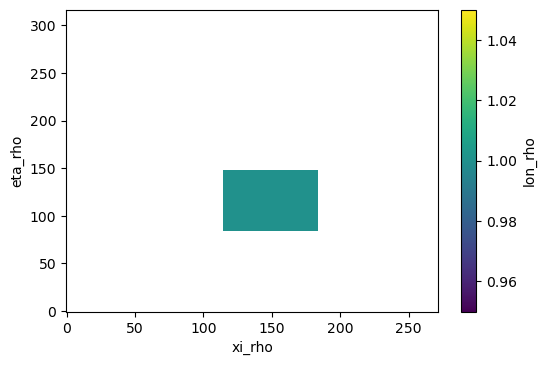

In [33]:
# Brief interlude to test the various area averaging functions
weights = truth_bu.dA
weights.name = "weights"

# make a mask
etaLims = etas #exclusive mask
xiLims = xis

mask = (np.ones((truth.dims['eta_rho'],truth.dims['xi_rho']))*(truth.lon_rho*0+1)).where((truth.eta_rho>etaLims[0]) & (truth.eta_rho<etaLims[1]) & (truth.xi_rho>xiLims[0]) & (truth.xi_rho<xiLims[1]))
mask.plot()
plt.show()
# test = truth.temp.isel(s_rho=-1).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho'))

In [34]:
truth["eke_mean"] = truth.eke.mean(dim='ocean_time')
truth.eke_mean.load()

baseline_barra["eke_mean"] = baseline_barra.eke.mean(dim='ocean_time')
baseline_barra.eke_mean.load()

baseline_access["eke_mean"] = baseline_access.eke.mean(dim='ocean_time')
baseline_access.eke_mean.load()

test1=np.zeros(30)
test2=np.zeros(30)
test3=np.zeros(30)
test4=np.zeros(30)
test5=np.zeros(30)
test6=np.zeros(30)

test11=np.zeros(30)
test12=np.zeros(30)
test13=np.zeros(30)

for ss in np.arange(0,29):
    
    test1[ss]=truth.eke_mean.isel(s_rho=ss).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho'))
    truth["eke_xymean"] = (('s_rho'),test1)
    test2[ss] = truth.z_rho0.isel(s_rho=ss).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho'))
    truth["z_rho_xymean"]=(('s_rho'),test2)
    test3[ss]=baseline_barra.eke_mean.isel(s_rho=ss).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho'))
    baseline_barra["eke_xymean"] = (('s_rho'),test3)
    test4[ss] = baseline_barra.z_rho0.isel(s_rho=ss).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho'))
    baseline_barra["z_rho_xymean"]=(('s_rho'),test4)    
    test5[ss]=baseline_access.eke_mean.isel(s_rho=ss).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho'))
    baseline_access["eke_xymean"] = (('s_rho'),test5)
    test6[ss] = baseline_access.z_rho0.isel(s_rho=ss).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho'))
    baseline_access["z_rho_xymean"]=(('s_rho'),test6)            
  

        
    test11[ss]=truth.eke_mean.isel(s_rho=ss).where(mask==1).weighted(weights).std(('eta_rho','xi_rho'))
    truth["eke_xystd"] = (('s_rho'),test11)
    test12[ss]=baseline_barra.eke_mean.isel(s_rho=ss).where(mask==1).weighted(weights).std(('eta_rho','xi_rho'))
    baseline_barra["eke_xystd"] = (('s_rho'),test12)
    test13[ss]=baseline_access.eke_mean.isel(s_rho=ss).where(mask==1).weighted(weights).std(('eta_rho','xi_rho'))
    baseline_access["eke_xystd"] = (('s_rho'),test13)

    

<Figure size 600x400 with 0 Axes>

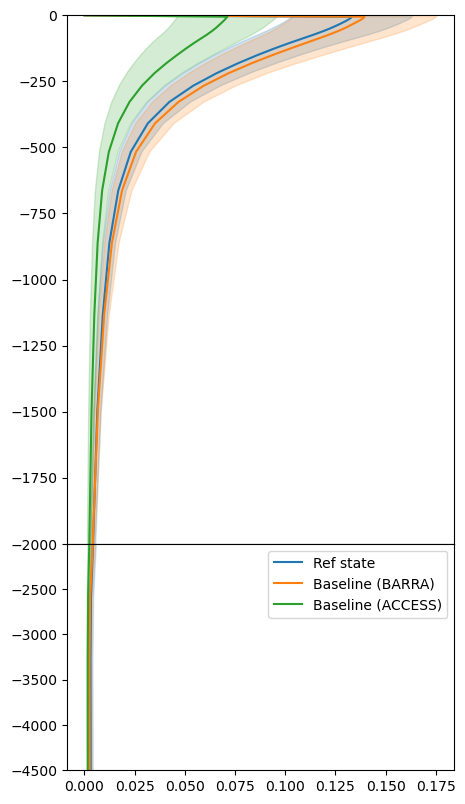

In [35]:


gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.05, hspace=0.00,height_ratios=[.7,.3])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[5,10])
ax = None

def plot_std(var,yvar,label):
    C_std = var.std('PROFILE')
    C.plot(y='DEPTH',label=label)
    plt.fill_betweenx(yvar, C-C_std,C+C_std, alpha=0.2)
    plt.ylim(max_depth,min(yvar))

ax = fig.add_subplot(gs[0,0])
ax.plot(truth.eke_xymean,truth.z_rho_xymean,label='Ref state')
ax.fill_betweenx(truth.z_rho_xymean,truth.eke_xymean-truth.eke_xystd,truth.eke_xymean+truth.eke_xystd, alpha=0.2, edgecolor='C0')
ax.plot(baseline_barra.eke_xymean,baseline_barra.z_rho_xymean,label='Baseline (BARRA)')
ax.fill_betweenx(baseline_barra.z_rho_xymean,baseline_barra.eke_xymean-baseline_barra.eke_xystd,baseline_barra.eke_xymean+baseline_barra.eke_xystd, alpha=0.2, edgecolor='C1')
ax.plot(baseline_access.eke_xymean,baseline_access.z_rho_xymean,label='Baseline (ACCESS)')
ax.fill_betweenx(baseline_access.z_rho_xymean,baseline_access.eke_xymean-baseline_access.eke_xystd,baseline_access.eke_xymean+baseline_access.eke_xystd, alpha=0.2, edgecolor='C2')

ax.set_ylim(-2000,0)
ax.set_xticklabels([])

ax = fig.add_subplot(gs[1,0])
ax.plot(truth.eke_xymean,truth.z_rho_xymean,label='Ref state')
ax.fill_betweenx(truth.z_rho_xymean,truth.eke_xymean-truth.eke_xystd,truth.eke_xymean+truth.eke_xystd, alpha=0.2, edgecolor='C0')
ax.plot(baseline_barra.eke_xymean,baseline_barra.z_rho_xymean,label='Baseline (BARRA)')
ax.fill_betweenx(baseline_barra.z_rho_xymean,baseline_barra.eke_xymean-baseline_barra.eke_xystd,baseline_barra.eke_xymean+baseline_barra.eke_xystd, alpha=0.2, edgecolor='C1')
ax.plot(baseline_access.eke_xymean,baseline_access.z_rho_xymean,label='Baseline (ACCESS)')
ax.fill_betweenx(baseline_access.z_rho_xymean,baseline_access.eke_xymean-baseline_access.eke_xystd,baseline_access.eke_xymean+baseline_access.eke_xystd, alpha=0.2, edgecolor='C2')

ax.set_ylim(-4500,-2001)



ax.legend()



# now make final plots

<Figure size 600x400 with 0 Axes>

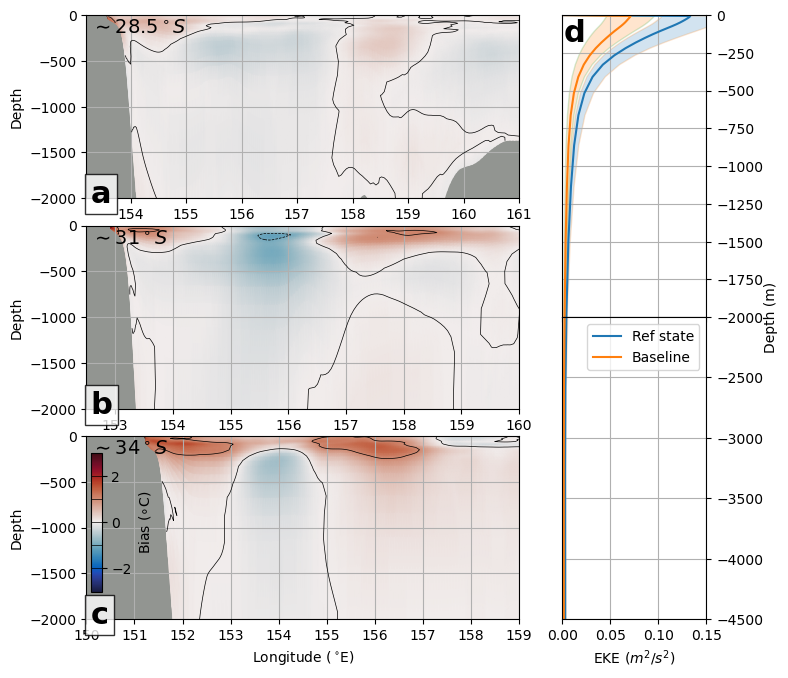

In [54]:
## test vertical transect

def addSubplot_VerticalTransect(X,Y,input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol])
    ax.set_facecolor('xkcd:grey')
    im = ax.pcolormesh(X,Y,input,shading='gouraud', **pcol_kwargs)
    # cax = inset_axes(ax,
    #              width="5%",  # width = 10% of parent_bbox width
    #              height="50%",  # height : 50%
    #              loc='lower left',
    #              bbox_to_anchor=(.05,.09, .8, .8),
    #              bbox_transform=ax.transAxes,
    #              borderpad=0,
    #              )
    ax.set_ylim([-2000,0])
    # cbar = fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.1, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
    ax.grid()
    return ax,im

def addSubplot_VerticalTransect_colorbar(X,Y,input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol])
    ax.set_facecolor('xkcd:grey')
    im = ax.pcolormesh(X,Y,input,shading='gouraud', **pcol_kwargs)
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.87,.56, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    cax.yaxis.tick_left()
    cax.set_ylabel('temp ($\circ C$)')
    ax.set_ylim([-2000,0])
    ax.text(0.01, 0.1, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
    ax.grid()
    return ax,cbar,im




plt.cla()
plt.clf()
fig = plt.figure(figsize=[8,8])
ax = None

gs = fig.add_gridspec(nrows=1,ncols=2,width_ratios=[0.75,.25],wspace=0.15)

gs00 = gs[0].subgridspec(3, 1,wspace=0.05, hspace=0.15)
gs01 = gs[1].subgridspec(2, 1,hspace=0.0)

# baseline_access
ax = addSubplot_VerticalTransect(x1,y1,bias_temp_baseline_access.isel(eta_rho=255),gs00,0,0,'a',pcol_kwargs={'cmap':'cmo.balance','vmin':-3,'vmax':3})
co = ax[0].contour(x1,y1,bias_temp_baseline_access.isel(eta_rho=255),levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
ax[0].set_ylabel('Depth')
# ax[0].text(-.27, .5, '$\sim27.5^\circ S$',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
ax[0].text(0.01, 0.98, '$\sim28.5^\circ S$', transform=ax[0].transAxes,fontsize=14, fontweight='bold', va='top')
# ax[0].text(-.15, .5, '',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
# ax[0].text(0.5, 1.12, 'Bias',fontsize=14, fontweight='bold', va='center', ha='center', rotation='horizontal', transform=ax[0].transAxes)
ax[0].set_xlim([153.2,161])
# ax[0].set_yticklabels([])
# ax[0].set_xticklabels([])

ax = addSubplot_VerticalTransect(x2,y2,bias_temp_baseline_access.isel(eta_rho=185),gs00,1,0,'b',pcol_kwargs={'cmap':'cmo.balance','vmin':-3,'vmax':3})
co = ax[0].contour(x2,y2,bias_temp_baseline_access.isel(eta_rho=185),levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
# ax[0].text(-.27, .5,  '$\sim32^\circ S$',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
ax[0].set_ylabel('Depth')
ax[0].text(0.01, 0.98, '$\sim31^\circ S$', transform=ax[0].transAxes,fontsize=14, fontweight='bold', va='top')
# ax[0].text(-.15, .5,  '$\sim31^\circ S$',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
# ax[0].set_xticklabels([])
# ax[0].set_yticklabels([])
ax[0].set_xlim([152.5,160])


ax  = addSubplot_VerticalTransect(x3,y3,bias_temp_baseline_access.isel(eta_rho=119),gs00,2,0,'c',pcol_kwargs={'cmap':'cmo.balance','vmin':-3,'vmax':3})
co = ax[0].contour(x3,y3,bias_temp_baseline_access.isel(eta_rho=119),levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
ax[0].text(0.01, 0.98, '$\sim34^\circ S$', transform=ax[0].transAxes,fontsize=14, fontweight='bold', va='top')
ax[0].set_ylabel('Depth')
ax[0].set_xlabel('Longitude ($^\circ\!$E)')
# ax[0].text(-.15, .5,  '$\sim34^\circ S$',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
# ax[0].text(-.27, .5,  '$\sim35.5^\circ S$',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
# ax[0].set_yticklabels([])
# ax[0].set_yticklabels([])
ax[0].set_xlim([150,159])
cax = inset_axes(ax[0],
                 width="5%",  # width = 10% of parent_bbox width
                 height="95%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(0.01,0.15, .5, .8),
                 bbox_transform=ax[0].transAxes,
                 borderpad=0,
                 )
cbar = fig.colorbar(ax[1], cax=cax)
cbar.ax.set_ylabel('Bias ($\circ$C)')
cbar.add_lines(co)

# now eke subpanel

def plot_std(var,yvar,label):
    C_std = var.std('PROFILE')
    C.plot(y='DEPTH',label=label)
    plt.fill_betweenx(yvar, C-C_std,C+C_std, alpha=0.2)
    plt.ylim(max_depth,min(yvar))

ax = fig.add_subplot(gs01[0,0])
ax.plot(truth.eke_xymean,truth.z_rho_xymean,label='Ref state')
# ax.fill_betweenx(truth.z_rho_xymean,truth.eke_xymean-truth.eke_xystd,truth.eke_xymean+truth.eke_xystd, alpha=0.2, edgecolor='C0')
# ax.plot(baseline_barra.eke_xymean,baseline_barra.z_rho_xymean,label='Baseline (BARRA)')
ax.fill_betweenx(baseline_barra.z_rho_xymean,baseline_barra.eke_xymean-baseline_barra.eke_xystd,baseline_barra.eke_xymean+baseline_barra.eke_xystd, alpha=0.2, edgecolor='C1')
ax.plot(baseline_access.eke_xymean,baseline_access.z_rho_xymean,label='Baseline')
ax.fill_betweenx(baseline_access.z_rho_xymean,baseline_access.eke_xymean-baseline_access.eke_xystd,baseline_access.eke_xymean+baseline_access.eke_xystd, alpha=0.2, edgecolor='C2')

ax.set_ylim(-2000,0)
ax.set_xlim(0,0.15)
ax.set_xticklabels([])
ax.text(0.01, 0.99, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.set_ylabel('Depth (m)')
ax.grid()
ax.yaxis.tick_right()
ax.yaxis.set_label_coords(1.5,0)

ax = fig.add_subplot(gs01[1,0])
ax.plot(truth.eke_xymean,truth.z_rho_xymean,label='Ref state')
# ax.fill_betweenx(truth.z_rho_xymean,truth.eke_xymean-truth.eke_xystd,truth.eke_xymean+truth.eke_xystd, alpha=0.2, edgecolor='C0')
# ax.plot(baseline_barra.eke_xymean,baseline_barra.z_rho_xymean,label='Baseline (BARRA)')
ax.fill_betweenx(baseline_barra.z_rho_xymean,baseline_barra.eke_xymean-baseline_barra.eke_xystd,baseline_barra.eke_xymean+baseline_barra.eke_xystd, alpha=0.2, edgecolor='C1')
ax.plot(baseline_access.eke_xymean,baseline_access.z_rho_xymean,label='Baseline')
ax.fill_betweenx(baseline_access.z_rho_xymean,baseline_access.eke_xymean-baseline_access.eke_xystd,baseline_access.eke_xymean+baseline_access.eke_xystd, alpha=0.2, edgecolor='C2')

ax.set_ylim(-4500,-2001)
ax.set_xlim(0,0.15)
ax.grid()
ax.set_xlabel('EKE ($m^2/s^2$)')
ax.yaxis.tick_right()
ax.legend()


ax.legend()




<Figure size 600x400 with 0 Axes>

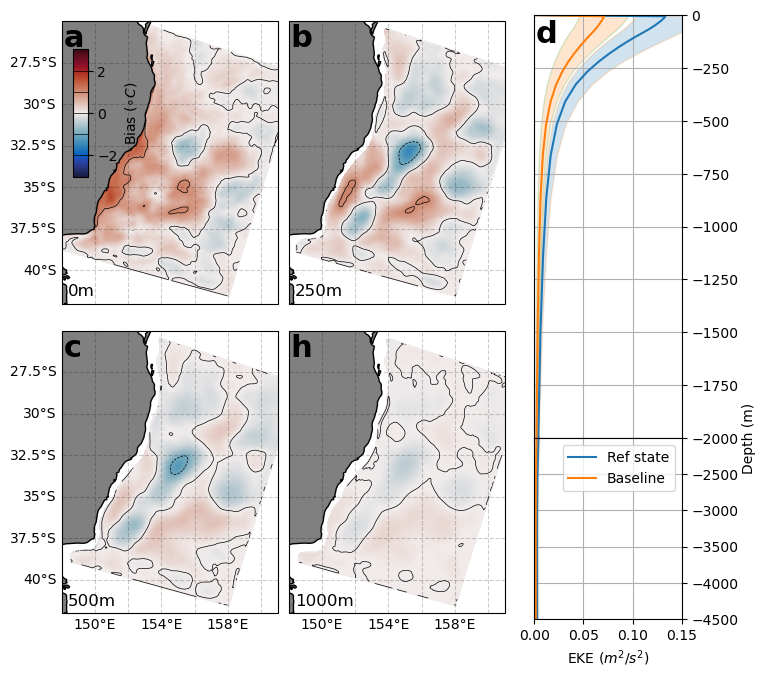

In [45]:
## test vertical transect

def addSubplot_VerticalTransect(X,Y,input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol])
    ax.set_facecolor('xkcd:grey')
    im = ax.pcolormesh(X,Y,input,shading='gouraud', **pcol_kwargs)
    # cax = inset_axes(ax,
    #              width="5%",  # width = 10% of parent_bbox width
    #              height="50%",  # height : 50%
    #              loc='lower left',
    #              bbox_to_anchor=(.05,.09, .8, .8),
    #              bbox_transform=ax.transAxes,
    #              borderpad=0,
    #              )
    ax.set_ylim([-2000,0])
    # cbar = fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.1, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
    ax.grid()
    return ax,im

def addSubplot_VerticalTransect_colorbar(X,Y,input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol])
    ax.set_facecolor('xkcd:grey')
    im = ax.pcolormesh(X,Y,input,shading='gouraud', **pcol_kwargs)
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.87,.56, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    cax.yaxis.tick_left()
    cax.set_ylabel('temp ($\circ C$)')
    ax.set_ylim([-2000,0])
    ax.text(0.01, 0.1, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
    ax.grid()
    return ax,cbar,im




plt.cla()
plt.clf()
fig = plt.figure(figsize=[8,8])
ax = None

gs = fig.add_gridspec(nrows=1,ncols=2,width_ratios=[0.75,.25],wspace=0.1)

gs00 = gs[0].subgridspec(2, 2,wspace=0.05, hspace=0.05)
gs01 = gs[1].subgridspec(2, 1,hspace=0.0,height_ratios=[0.7,0.3])

# baseline_access



ax = addSubplot_spatialMap(bias_temp_baseline_access.isel(s_rho=-1)   ,gs00,0,0,'a',pcol_kwargs={'cmap':'cmo.balance','vmin':-3,'vmax':3})
co = (bias_temp_baseline_access.isel(s_rho=-1)).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
ax[1].left_labels = True
# cbar.add_lines(co)
ax[0].set_title('')
# ax[0].text(0.5, 1.1, 'Baseline (ACCESS)',fontsize=14, fontweight='bold', va='center', ha='center', rotation='horizontal', transform=ax[0].transAxes)
# transectEta=255
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# ax[0].text(.05, .08, '$\overline{\mathrm{Bias}}$='+str(np.round( grid.average(bias_temp_2W125.isel(s_rho=-1),['X','Y']).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# ax[0].text(.45, .08,  '$\overline{\mathrm{Bias}\,}_\mathrm{EDDY}$='+str(np.round( bias_temp_2W125.isel(s_rho=-1).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho')).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# boxLo,boxLa = calc_boxSpatial(truth,etaRange=etaLims,xiRange=xiLims)
# plt.plot(boxLo,boxLa,color='C0',linewidth=1)
# ax[0].text(-.26, .5, 'temp (0 m)',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)
ax[0].text(0.03, 0.07, '0m', transform=ax[0].transAxes,fontsize=12, va='top',ha='left')
cax = inset_axes(ax[0],
                 width="7%",  # width = 10% of parent_bbox width
                 height="45%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(0.05,0.45, 1, 1),
                 bbox_transform=ax[0].transAxes,
                 borderpad=0,
                 )
cbar = fig.colorbar(ax[2], cax=cax)
cbar.ax.set_ylabel('Bias ($\circ C$)')
cbar.add_lines(co)

ax = addSubplot_spatialMap(horizontalSectionROMS(grid, bias_temp_baseline_access, np.array([-500]))   ,gs00,1,0,'c',pcol_kwargs={'cmap':'cmo.balance','vmin':-3,'vmax':3})
co = (horizontalSectionROMS(grid, bias_temp_baseline_access, np.array([-500]))).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
ax[1].left_labels = True
ax[1].bottom_labels = True
# cbar.add_lines(co)
ax[0].set_title('')
# # ax[0].text(0.5, 1.1, 'W-12.5',fontsize=14, fontweight='bold', va='center', ha='center', rotation='horizontal', transform=ax[0].transAxes)
# transectEta=255
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# ax[0].text(.05, .08, '$\overline{\mathrm{Bias}}$='+str(np.round( grid.average(horizontalSectionROMS(grid, bias_temp_2W125, np.array([-250])),['X','Y']).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# ax[0].text(.45, .08,  '$\overline{\mathrm{Bias}\,}_\mathrm{EDDY}$='+str(np.round( horizontalSectionROMS(grid, bias_temp_2W125, np.array([-250])).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho')).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# boxLo,boxLa = calc_boxSpatial(truth,etaRange=etaLims,xiRange=xiLims)
# plt.plot(boxLo,boxLa,color='C0',linewidth=1)
# ax[0].text(-.26, .5, 'temp (250 m)',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)

ax[0].text(0.03, 0.07, '500m', transform=ax[0].transAxes,fontsize=12, va='top',ha='left')

ax = addSubplot_spatialMap(horizontalSectionROMS(grid, bias_temp_baseline_access, np.array([-250]))   ,gs00,0,1,'b',pcol_kwargs={'cmap':'cmo.balance','vmin':-3,'vmax':3})
co = (horizontalSectionROMS(grid, bias_temp_baseline_access, np.array([-250]))).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
# ax[1].left_labels = True
# ax[1].bottom_labels = True
ax[0].set_title('')
# transectEta=255
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# # ax[0].text(.05, .03, '$\overline{\mathrm{RMS}}$='+str(np.round( grid.average(RMSD_SSHSST_PXLINES_WEEKLY_TRUTH_temp500,['X','Y']).values,2))+'$\!^\circ\!$C',fontsize=9, va='center', ha='left', transform=ax[0].transAxes)
# ax[0].text(.05, .08, '$\overline{\mathrm{Bias}}$='+str(np.round( grid.average(horizontalSectionROMS(grid, bias_temp_2W125, np.array([-500])),['X','Y']).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# ax[0].text(.45, .08,  '$\overline{\mathrm{Bias}\,}_\mathrm{EDDY}$='+str(np.round( horizontalSectionROMS(grid, bias_temp_2W125, np.array([-500])).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho')).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
ax[0].text(0.03, 0.07, '250m', transform=ax[0].transAxes,fontsize=12, va='top',ha='left')


ax = addSubplot_spatialMap(horizontalSectionROMS(grid, bias_temp_baseline_access, np.array([-1000]))   ,gs00,1,1,'h',pcol_kwargs={'cmap':'cmo.balance','vmin':-3,'vmax':3})
co = (horizontalSectionROMS(grid, bias_temp_baseline_access, np.array([-1000]))).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
ax[0].set_title('')
# ax[1].left_labels = True
ax[1].bottom_labels = True
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# # ax[0].text(.05, .03, '$\overline{\mathrm{RMS}}$='+str(np.round( grid.average(RMSD_SSHSST_PXLINES_WEEKLY_TRUTH_temp1000,['X','Y']).values,2))+'$\!^\circ\!$C',fontsize=9, va='center', ha='left', transform=ax[0].transAxes)
# ax[0].text(.05, .08, '$\overline{\mathrm{Bias}}$='+str(np.round( grid.average(horizontalSectionROMS(grid, bias_temp_2W125, np.array([-1000])),['X','Y']).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
# ax[0].text(.45, .08,  '$\overline{\mathrm{Bias}\,}_\mathrm{EDDY}$='+str(np.round( horizontalSectionROMS(grid, bias_temp_2W125, np.array([-1000])).where(mask==1).weighted(weights).mean(('eta_rho','xi_rho')).values,1))+'$\!^\circ\!$C',fontsize=9, va='top', ha='left', transform=ax[0].transAxes)
ax[0].text(0.03, 0.07, '1000m', transform=ax[0].transAxes,fontsize=12, va='top',ha='left')









# ###########




# ax = addSubplot_VerticalTransect(x1,y1,bias_temp_baseline_access.isel(eta_rho=255),gs00,0,0,'a',pcol_kwargs={'cmap':'cmo.balance','vmin':-2,'vmax':2})
# co = ax[0].contour(x1,y1,bias_temp_baseline_access.isel(eta_rho=255),levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
# ax[0].set_ylabel('Depth')
# # ax[0].text(-.27, .5, '$\sim27.5^\circ S$',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
# ax[0].text(0.01, 0.99, '$\sim28.5^\circ S$', transform=ax[0].transAxes,fontsize=14, fontweight='bold', va='top')
# # ax[0].text(-.15, .5, '',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
# # ax[0].text(0.5, 1.12, 'Bias',fontsize=14, fontweight='bold', va='center', ha='center', rotation='horizontal', transform=ax[0].transAxes)
# ax[0].set_xlim([153.2,161])
# # ax[0].set_yticklabels([])
# ax[0].set_xticklabels([])

# ax = addSubplot_VerticalTransect(x2,y2,bias_temp_baseline_access.isel(eta_rho=185),gs00,1,0,'b',pcol_kwargs={'cmap':'cmo.balance','vmin':-2,'vmax':2})
# co = ax[0].contour(x2,y2,bias_temp_baseline_access.isel(eta_rho=185),levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
# # ax[0].text(-.27, .5,  '$\sim32^\circ S$',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
# ax[0].set_ylabel('Depth')
# ax[0].text(0.01, 0.99, '$\sim31^\circ S$', transform=ax[0].transAxes,fontsize=14, fontweight='bold', va='top')
# # ax[0].text(-.15, .5,  '$\sim31^\circ S$',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
# ax[0].set_xticklabels([])
# # ax[0].set_yticklabels([])
# ax[0].set_xlim([152.5,160])


# ax  = addSubplot_VerticalTransect(x3,y3,bias_temp_baseline_access.isel(eta_rho=119),gs00,2,0,'c',pcol_kwargs={'cmap':'cmo.balance','vmin':-2,'vmax':2})
# co = ax[0].contour(x3,y3,bias_temp_baseline_access.isel(eta_rho=119),levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
# ax[0].text(0.01, 0.99, '$\sim34^\circ S$', transform=ax[0].transAxes,fontsize=14, fontweight='bold', va='top')
# ax[0].set_ylabel('Depth')
# ax[0].set_xlabel('Longitude ($^\circ$E)')
# # ax[0].text(-.15, .5,  '$\sim34^\circ S$',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
# # ax[0].text(-.27, .5,  '$\sim35.5^\circ S$',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
# # ax[0].set_yticklabels([])
# # ax[0].set_yticklabels([])
# ax[0].set_xlim([150,159])
# cax = inset_axes(ax[0],
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="95%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(0.01,0.15, .5, .8),
#                  bbox_transform=ax[0].transAxes,
#                  borderpad=0,
#                  )
# cbar = fig.colorbar(ax[1], cax=cax)
# cbar.ax.set_ylabel('Bias ($\circ$C)')
# cbar.add_lines(co)

# now eke subpanel

def plot_std(var,yvar,label):
    C_std = var.std('PROFILE')
    C.plot(y='DEPTH',label=label)
    plt.fill_betweenx(yvar, C-C_std,C+C_std, alpha=0.2)
    plt.ylim(max_depth,min(yvar))

ax = fig.add_subplot(gs01[0,0])
ax.plot(truth.eke_xymean,truth.z_rho_xymean,label='Ref state')
# ax.fill_betweenx(truth.z_rho_xymean,truth.eke_xymean-truth.eke_xystd,truth.eke_xymean+truth.eke_xystd, alpha=0.2, edgecolor='C0')
# ax.plot(baseline_barra.eke_xymean,baseline_barra.z_rho_xymean,label='Baseline (BARRA)')
ax.fill_betweenx(baseline_barra.z_rho_xymean,baseline_barra.eke_xymean-baseline_barra.eke_xystd,baseline_barra.eke_xymean+baseline_barra.eke_xystd, alpha=0.2, edgecolor='C1')
ax.plot(baseline_access.eke_xymean,baseline_access.z_rho_xymean,label='Baseline')
ax.fill_betweenx(baseline_access.z_rho_xymean,baseline_access.eke_xymean-baseline_access.eke_xystd,baseline_access.eke_xymean+baseline_access.eke_xystd, alpha=0.2, edgecolor='C2')

ax.set_ylim(-2000,0)
ax.set_xlim(0,0.15)
ax.set_xticklabels([])
ax.text(0.01, 0.99, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.set_ylabel('Depth (m)')
ax.grid()
ax.yaxis.tick_right()
ax.yaxis.set_label_coords(1.5,0)

ax = fig.add_subplot(gs01[1,0])
ax.plot(truth.eke_xymean,truth.z_rho_xymean,label='Ref state')
# ax.fill_betweenx(truth.z_rho_xymean,truth.eke_xymean-truth.eke_xystd,truth.eke_xymean+truth.eke_xystd, alpha=0.2, edgecolor='C0')
# ax.plot(baseline_barra.eke_xymean,baseline_barra.z_rho_xymean,label='Baseline (BARRA)')
ax.fill_betweenx(baseline_barra.z_rho_xymean,baseline_barra.eke_xymean-baseline_barra.eke_xystd,baseline_barra.eke_xymean+baseline_barra.eke_xystd, alpha=0.2, edgecolor='C1')
ax.plot(baseline_access.eke_xymean,baseline_access.z_rho_xymean,label='Baseline')
ax.fill_betweenx(baseline_access.z_rho_xymean,baseline_access.eke_xymean-baseline_access.eke_xystd,baseline_access.eke_xymean+baseline_access.eke_xystd, alpha=0.2, edgecolor='C2')

ax.set_ylim(-4500,-2001)
ax.set_xlim(0,0.15)
ax.grid()
ax.set_xlabel('EKE ($m^2/s^2$)')
ax.yaxis.tick_right()
ax.legend()


ax.legend()




<Figure size 600x400 with 0 Axes>

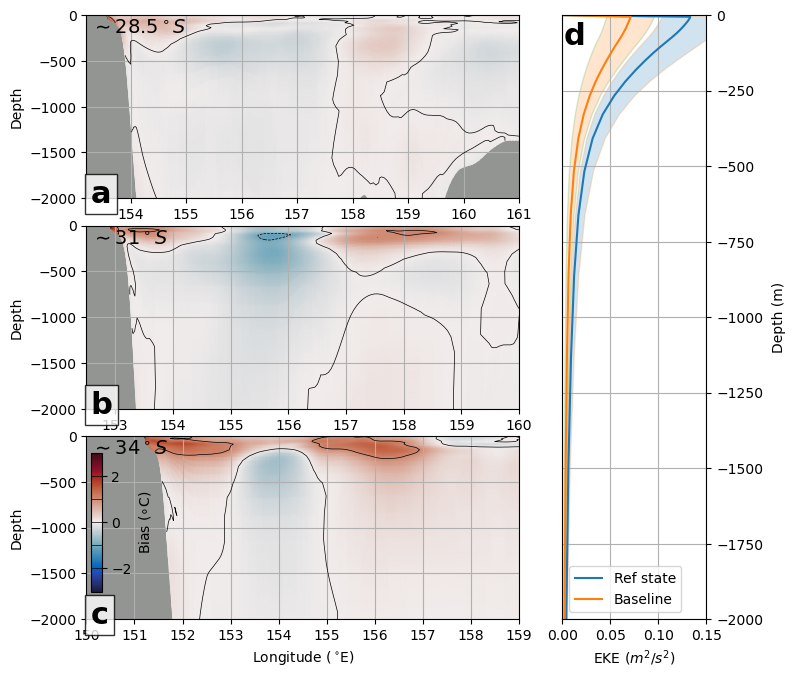

In [58]:
## test vertical transect

def addSubplot_VerticalTransect(X,Y,input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol])
    ax.set_facecolor('xkcd:grey')
    im = ax.pcolormesh(X,Y,input,shading='gouraud', **pcol_kwargs)
    # cax = inset_axes(ax,
    #              width="5%",  # width = 10% of parent_bbox width
    #              height="50%",  # height : 50%
    #              loc='lower left',
    #              bbox_to_anchor=(.05,.09, .8, .8),
    #              bbox_transform=ax.transAxes,
    #              borderpad=0,
    #              )
    ax.set_ylim([-2000,0])
    # cbar = fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.1, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
    ax.grid()
    return ax,im

def addSubplot_VerticalTransect_colorbar(X,Y,input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol])
    ax.set_facecolor('xkcd:grey')
    im = ax.pcolormesh(X,Y,input,shading='gouraud', **pcol_kwargs)
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.87,.56, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    cax.yaxis.tick_left()
    cax.set_ylabel('temp ($\circ C$)')
    ax.set_ylim([-2000,0])
    ax.text(0.01, 0.1, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
    ax.grid()
    return ax,cbar,im




plt.cla()
plt.clf()
fig = plt.figure(figsize=[8,8])
ax = None

gs = fig.add_gridspec(nrows=1,ncols=2,width_ratios=[0.75,.25],wspace=0.15)

gs00 = gs[0].subgridspec(3, 1,wspace=0.05, hspace=0.15)
gs01 = gs[1].subgridspec(1, 1,hspace=0.0)

# baseline_access
ax = addSubplot_VerticalTransect(x1,y1,bias_temp_baseline_access.isel(eta_rho=255),gs00,0,0,'a',pcol_kwargs={'cmap':'cmo.balance','vmin':-3,'vmax':3})
co = ax[0].contour(x1,y1,bias_temp_baseline_access.isel(eta_rho=255),levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
ax[0].set_ylabel('Depth')
# ax[0].text(-.27, .5, '$\sim27.5^\circ S$',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
ax[0].text(0.01, 0.98, '$\sim28.5^\circ S$', transform=ax[0].transAxes,fontsize=14, fontweight='bold', va='top')
# ax[0].text(-.15, .5, '',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
# ax[0].text(0.5, 1.12, 'Bias',fontsize=14, fontweight='bold', va='center', ha='center', rotation='horizontal', transform=ax[0].transAxes)
ax[0].set_xlim([153.2,161])
# ax[0].set_yticklabels([])
# ax[0].set_xticklabels([])

ax = addSubplot_VerticalTransect(x2,y2,bias_temp_baseline_access.isel(eta_rho=185),gs00,1,0,'b',pcol_kwargs={'cmap':'cmo.balance','vmin':-3,'vmax':3})
co = ax[0].contour(x2,y2,bias_temp_baseline_access.isel(eta_rho=185),levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
# ax[0].text(-.27, .5,  '$\sim32^\circ S$',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
ax[0].set_ylabel('Depth')
ax[0].text(0.01, 0.98, '$\sim31^\circ S$', transform=ax[0].transAxes,fontsize=14, fontweight='bold', va='top')
# ax[0].text(-.15, .5,  '$\sim31^\circ S$',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
# ax[0].set_xticklabels([])
# ax[0].set_yticklabels([])
ax[0].set_xlim([152.5,160])


ax  = addSubplot_VerticalTransect(x3,y3,bias_temp_baseline_access.isel(eta_rho=119),gs00,2,0,'c',pcol_kwargs={'cmap':'cmo.balance','vmin':-3,'vmax':3})
co = ax[0].contour(x3,y3,bias_temp_baseline_access.isel(eta_rho=119),levels=np.arange(-5,6,1),colors='k',zorder=12,linewidths=0.5)
ax[0].text(0.01, 0.98, '$\sim34^\circ S$', transform=ax[0].transAxes,fontsize=14, fontweight='bold', va='top')
ax[0].set_ylabel('Depth')
ax[0].set_xlabel('Longitude ($^\circ\!$E)')
# ax[0].text(-.15, .5,  '$\sim34^\circ S$',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
# ax[0].text(-.27, .5,  '$\sim35.5^\circ S$',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
# ax[0].set_yticklabels([])
# ax[0].set_yticklabels([])
ax[0].set_xlim([150,159])
cax = inset_axes(ax[0],
                 width="5%",  # width = 10% of parent_bbox width
                 height="95%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(0.01,0.15, .5, .8),
                 bbox_transform=ax[0].transAxes,
                 borderpad=0,
                 )
cbar = fig.colorbar(ax[1], cax=cax)
cbar.ax.set_ylabel('Bias ($\circ$C)')
cbar.add_lines(co)

# now eke subpanel

def plot_std(var,yvar,label):
    C_std = var.std('PROFILE')
    C.plot(y='DEPTH',label=label)
    plt.fill_betweenx(yvar, C-C_std,C+C_std, alpha=0.2)
    plt.ylim(max_depth,min(yvar))

ax = fig.add_subplot(gs01[0,0])
ax.plot(truth.eke_xymean,truth.z_rho_xymean,label='Ref state')
# ax.fill_betweenx(truth.z_rho_xymean,truth.eke_xymean-truth.eke_xystd,truth.eke_xymean+truth.eke_xystd, alpha=0.2, edgecolor='C0')
# ax.plot(baseline_barra.eke_xymean,baseline_barra.z_rho_xymean,label='Baseline (BARRA)')
ax.fill_betweenx(baseline_barra.z_rho_xymean,baseline_barra.eke_xymean-baseline_barra.eke_xystd,baseline_barra.eke_xymean+baseline_barra.eke_xystd, alpha=0.2, edgecolor='C1')
ax.plot(baseline_access.eke_xymean,baseline_access.z_rho_xymean,label='Baseline')
ax.fill_betweenx(baseline_access.z_rho_xymean,baseline_access.eke_xymean-baseline_access.eke_xystd,baseline_access.eke_xymean+baseline_access.eke_xystd, alpha=0.2, edgecolor='C2')

ax.set_ylim(-2000,0)
ax.set_xlim(0,0.15)
# ax.set_xticklabels([])
ax.text(0.01, 0.99, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.set_ylabel('Depth (m)')
ax.grid()
ax.yaxis.tick_right()
ax.yaxis.set_label_coords(1.55,.5)

# ax = fig.add_subplot(gs01[1,0])
# ax.plot(truth.eke_xymean,truth.z_rho_xymean,label='Ref state')
# # ax.fill_betweenx(truth.z_rho_xymean,truth.eke_xymean-truth.eke_xystd,truth.eke_xymean+truth.eke_xystd, alpha=0.2, edgecolor='C0')
# # ax.plot(baseline_barra.eke_xymean,baseline_barra.z_rho_xymean,label='Baseline (BARRA)')
# ax.fill_betweenx(baseline_barra.z_rho_xymean,baseline_barra.eke_xymean-baseline_barra.eke_xystd,baseline_barra.eke_xymean+baseline_barra.eke_xystd, alpha=0.2, edgecolor='C1')
# ax.plot(baseline_access.eke_xymean,baseline_access.z_rho_xymean,label='Baseline')
# ax.fill_betweenx(baseline_access.z_rho_xymean,baseline_access.eke_xymean-baseline_access.eke_xystd,baseline_access.eke_xymean+baseline_access.eke_xystd, alpha=0.2, edgecolor='C2')

# ax.set_ylim(-4500,-2001)
# ax.set_xlim(0,0.15)
# ax.grid()
ax.set_xlabel('EKE ($m^2/s^2$)')
# ax.yaxis.tick_right()
# ax.legend()


ax.legend()


